## <span style="color:green"> Notebook - Inversion  </span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

Inversion module currently involves only inverting for conductivit

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pide
from pide.inversion import conductivity_solver_single_param
from pide.geodyn.geotherm import calculate_hasterok2011_geotherm

In [2]:
moho = 38 #km
max_depth = 250

T, depth, p, idx_LAB = calculate_hasterok2011_geotherm(SHF = 40, T_0 =25.0,max_depth = max_depth, moho = moho)

In [3]:
p_obj = pide.pide() #creating the initial object
p_obj.set_temperature(T)
p_obj.set_pressure(p)

p_obj.set_composition_solid_mineral(ol = 0.65, opx = 0.2, cpx = 0.1, garnet = 0.05)
p_obj.set_phase_interconnectivities(ol = 1, opx = 2, cpx = 4, gt = 4)



In [4]:
p_obj.set_mantle_water_solubility(ol = 4,opx = 3, cpx = 0, garnet = 0)
p_obj.set_mantle_water_partitions(opx_ol = 3, cpx_ol = 4, garnet_ol = 0)
p_obj.revalue_arrays()

In [5]:
p_obj.set_parameter('ti_ol', 0.1)
max_water = p_obj.calculate_bulk_mantle_water_solubility(method = 'array')

In [6]:
cond_list_to_invert = np.ones(len(T)) * 1e4
cond_list_to_invert[75:100] = 1000
cond_list_to_invert[100:150] = 100
cond_list_to_invert[150:] = 50
cond_list_to_invert = 1.0 / cond_list_to_invert #converting to conductivity

In [7]:
c_list, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_list_to_invert, param_name = 'bulk_water', upper_limit_list = max_water,
lower_limit_list= np.zeros(len(max_water)), search_start = 10, acceptence_threshold = 0.5, num_cpu = 5)

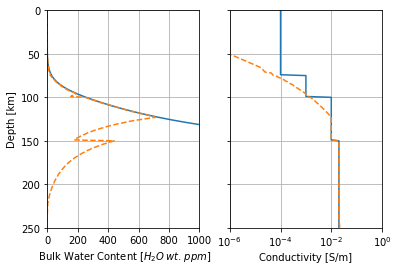

In [8]:
p_obj.set_bulk_water(c_list)
p_obj.mantle_water_distribute(method = 'array')
cond_calced = p_obj.calculate_conductivity(method = 'array')

fig = plt.figure()
ax = plt.subplot(121)
# ax.plot(cond_list,object.T,label = 'data')
# ax.plot(cond_calced,object.T, label = 'calced')
ax.plot(max_water,depth)
ax.plot(c_list,depth,linestyle = '--')
ax.set_ylim(np.amax(depth),np.amin(depth))
ax.set_xlim(0,1000)
ax.set_ylabel('Depth [km]')
ax.set_xlabel(r' Bulk Water Content [$H_2O \, wt. \, ppm$]')
ax.grid()

ax2 = plt.subplot(122)
ax2.plot(cond_list_to_invert,depth)
ax2.plot(cond_calced,depth,linestyle = '--')
ax2.set_xscale('log')
ax2.set_ylim(np.amax(depth),np.amin(depth))
ax2.set_xlim(1e-6,1)
ax2.set_yticklabels([])
ax2.set_xlabel('Conductivity [S/m]')
ax2.grid()

plt.show()